# Training the SPOCK model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
try:
    plt.style.use('paper.mplstyle')
except:
    pass
%matplotlib inline

Start by loading the training data generated with genNewTrainData.ipynb

In [2]:
#load datapath for clean training data
#datapath = '../../cleanData/csvs/resonant/'

dataset = pd.read_csv('../modeldata/1grantData.csv')
#remove junk columns
dataset = dataset.drop(columns=['Unnamed: 0','Unnamed: 0.1'])

In [3]:
dataset.describe()

,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,twoMMRstrengthnear,MMRstrengthWnear,MMRstrengthWMAXnear,twoMMRstrengthWnear,twoMMRstrengthWMAXnear,EMcrossfar,...,Zval12,Zcrit12,Zval23,Zcrit23,IntZval12,IntZval23,3BRfirstfillfac,InitialStable,instability_time,shadow_instability_time
count,102497.000000,95866.000000,95866.000000,95862.000000,95862.000000,95866.000000,1.024970e+05,95866.000000,1.024970e+05,102497.000000,...,102497.000000,102497.000000,102497.000000,102497.000000,102497.000000,102497.000000,102497.000000,102497.000000,1.024970e+05,1.024970e+05
mean,0.144542,0.073027,0.003730,0.672775,0.029735,0.007975,6.622659e+01,0.007859,6.622797e+01,0.358875,...,0.042687,0.079801,0.038908,0.080463,0.050193,0.046709,0.107642,0.935305,2.602292e+08,2.679298e+08
std,0.103741,0.100293,0.007316,2.061404,0.401513,0.027534,1.840728e+04,0.027365,1.840765e+04,0.200712,...,0.048974,0.065946,0.040734,0.067009,0.051292,0.043690,0.184254,0.245987,4.221284e+08,4.285158e+08
min,0.012845,0.000130,0.000001,0.000003,0.000000,0.000000,1.211123e-05,0.000000,0.000000e+00,0.020136,...,0.000034,0.000172,0.000012,0.000049,0.000085,0.000075,0.000000,0.000000,1.000287e+04,0.000000e+00
25%,0.072808,0.021790,0.000338,0.071852,0.007831,0.001822,2.958055e-03,0.001952,2.757583e-03,0.199495,...,0.011882,0.022109,0.011487,0.021781,0.017244,0.016812,0.027744,1.000000,8.373884e+04,7.563998e+04
50%,0.117834,0.041283,0.001080,0.171239,0.017067,0.004363,6.521910e-03,0.004378,6.036002e-03,0.315298,...,0.026587,0.063104,0.025445,0.063765,0.034008,0.033114,0.062768,1.000000,1.390492e+06,1.410175e+06
75%,0.182629,0.079991,0.003725,0.571251,0.030920,0.010166,1.356427e-02,0.009280,1.254937e-02,0.484311,...,0.054871,0.125913,0.051704,0.126431,0.064707,0.061913,0.130210,1.000000,4.969742e+08,7.897363e+08
max,0.982453,3.851351,0.159713,231.020184,78.725492,3.595468,5.860477e+06,3.583199,5.860596e+06,1.194679,...,0.593743,0.289177,0.462893,0.319780,0.692172,0.467353,20.017639,1.000000,1.000000e+09,1.000000e+09


In [4]:
dataset['InitialStable'].value_counts()

InitialStable
1.0    95866
0.0     6631
Name: count, dtype: int64

In [5]:
dataset['MEGNO'].isna().sum()

6631

We can then split the data into training and testing sets, note, we will remove systems that go unstable in 1e4 orbits from the testing set

In [6]:
def train_test(dataset,features):
    '''divides the dataset into 80% training and 20% testing and returns training/testing sets'''
    Nrows = int(0.8*dataset.shape[0])
    train = dataset.iloc[:Nrows, :]
    test = dataset.iloc[Nrows:, :]
    #remove testing systems that go unstable in 1e4 orbits
    test = test.drop(test[test['InitialStable']==False].index)
    return train[features], train['Stable'], test[features], test['Stable']

In [7]:
dataset['z12']=dataset['IntZval12']/dataset['Zcrit12']
dataset['z23']=dataset['IntZval23']/dataset['Zcrit23']

In [8]:
dataset['2BRindicator']=np.log10(dataset['ThetaSTD']/1.8)

In [9]:
dataset.columns

Index(['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear',
       'twoMMRstrengthnear', 'MMRstrengthWnear', 'MMRstrengthWMAXnear',
       'twoMMRstrengthWnear', 'twoMMRstrengthWMAXnear', 'EMcrossfar',
       'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar', 'twoMMRstrengthfar',
       'MMRstrengthWfar', 'MMRstrengthWMAXfar', 'twoMMRstrengthWfar',
       'twoMMRstrengthWMAXfar', 'EMcrossouter', 'EMfracstdouter', 'EPstdouter',
       'MMRstrengthouter', 'twoMMRstrengthouter', 'MMRstrengthWouter',
       'MMRstrengthWMAXouter', 'twoMMRstrengthWouter',
       'twoMMRstrengthWMAXouter', 'MEGNO', 'MEGNOstd', 'threeBRfillfac',
       '3Bfirstfillfac', 'threeBRfillstd', 'chiSec', 'ThetaSTD', 'p2/1',
       'p3/2', 'logInstT3BR', 'Zval12', 'Zcrit12', 'Zval23', 'Zcrit23',
       'IntZval12', 'IntZval23', '3BRfirstfillfac', 'InitialStable',
       'runstring', 'instability_time', 'shadow_instability_time', 'Stable',
       'z12', 'z23', '2BRindicator'],
      dtype='object')

In [33]:
all = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear',
       'twoMMRstrengthnear',  'EMcrossfar',
       'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar', 'twoMMRstrengthfar',
        'EMcrossouter', 'EMfracstdouter', 'EPstdouter',
       'MMRstrengthouter', 'twoMMRstrengthouter',
        'MEGNO', 'MEGNOstd', 'threeBRfillfac',
       '3Bfirstfillfac', 'threeBRfillstd', 'chiSec', '3BRfirstfillfac',
       'z12', 'z23','2BRindicator']

In [34]:
near = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear','twoMMRstrengthnear']
outer = ['EMcrossouter', 'EMfracstdouter', 'EPstdouter', 'MMRstrengthouter','twoMMRstrengthouter']
far = ['EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar','twoMMRstrengthfar']
megno = ['MEGNO', 'MEGNOstd']

features = near + far + megno +['threeBRfillfac','z12','z23','2BRindicator']

trainX, trainY, testX, testY = train_test(dataset, all)

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)

# Tuning hyperparameter
We can determine the idea values for the different hyperparameters.

We will start by creating and testing a collection of models that have randomly selected hyperparameters

scale_pos_weight is a hyperparameter used to account for skewed training data, it does this by weighting false positives and negatives differently. A typical value can be obtained by dividing your negative outcomes in your training data by your positive outcomes.

In [14]:
trainingBalance = trainY.value_counts()[False]/trainY.value_counts()[True]

We can then establish the different parameter space that we will be testing different hyperparameter values within.

In [23]:
space ={'max_depth': hp.qloguniform('x_max_depth', np.log(5), np.log(40), 1),
        'min_child_weight': hp.loguniform('x_min_child', 0, np.log(30)),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
}

def objective(params):
    clf = XGBClassifier(n_estimators = 300,
                            max_depth = int(params['max_depth']), 
                            min_child_weight = params['min_child_weight'],
                            subsample = params['subsample'],
                            learning_rate = 0.1, seed = 0,
                            scale_pos_weight = trainingBalance)
    
    score = xgb.cv(clf.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    print("SCORE:", avg_score, "ERROR", error)#, "HOLDOUT SCORE", test_score)
    return{'loss':1-avg_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error}


We can then create and evaluate the different trials

In [16]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 100, trials = trials, rstate=np.random.default_rng(seed=0))
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                                 
0.9330726384849204                                     
ERROR                                                  
0.0025812567542855287                                  
SCORE:                                                                            
0.9327580767753834                                                                
ERROR                                                                             
0.0023918436894987184                                                             
SCORE:                                                                            
0.9408896889854172                                                                
ERROR                                                                             
0.0022325612951780626                                                             
SCORE:                                                                            
0.9373796283283097           

We can not determine what values for hyperparameters will be ideal. We can do this by plotting how AUC changes as we alter each hyperparameter.

Here we will find that an optimal max_depth would be 15, which gives the best performance without over fitting.

Text(0, 0.5, 'CV AUC')

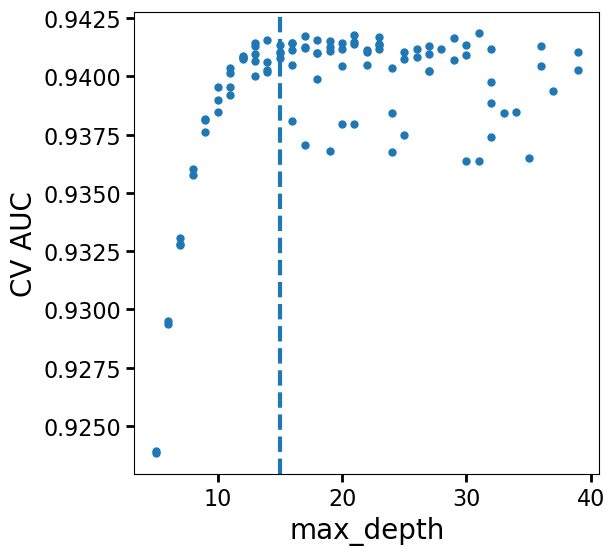

In [17]:
depths = trials.vals['x_max_depth']
min_childs = trials.vals['x_min_child']
subsample = trials.vals['x_subsample']
aucs = np.array([1-x['loss'] for x in trials.results])
fig, ax = plt.subplots()
ax.plot(depths, aucs, '.')
ax.axvline(15, linestyle='--')
ax.set_xlabel('max_depth')
ax.set_ylabel('CV AUC')

Here we will find that an optimal min_childs would be 10, which gives the best performance without over fitting.

Text(0, 0.5, 'CV AUC')

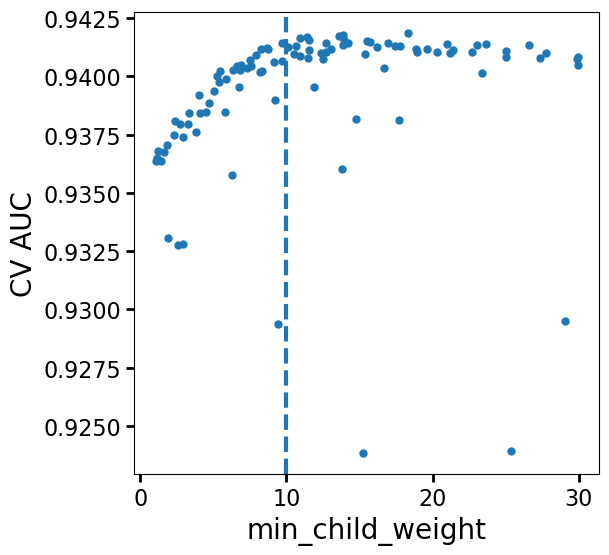

In [18]:
fig, ax = plt.subplots()
ax.plot(min_childs, aucs, '.')
ax.axvline(10, linestyle='--')
ax.set_xlabel('min_child_weight')
ax.set_ylabel('CV AUC')

Here we will find that an optimal subsample value would be 0.95 due to a malignly higher concentration of high preforming models. Most values seem to give good enough results.

Text(0, 0.5, 'CV AUC')

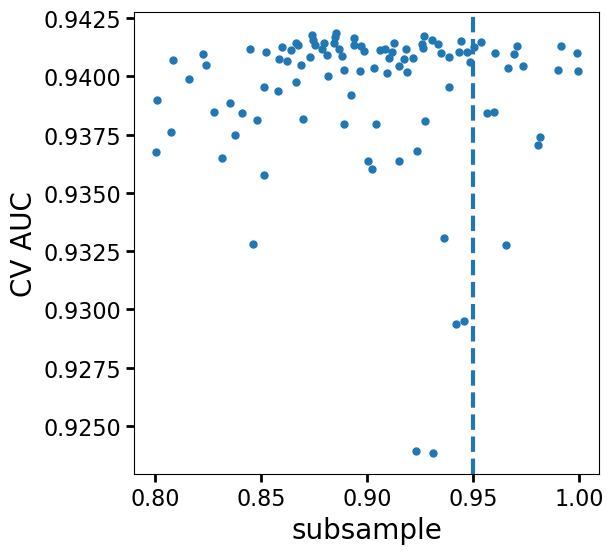

In [19]:
fig, ax = plt.subplots()
ax.plot(subsample, aucs, '.')
ax.axvline(.95, linestyle='--')
ax.set_xlabel('subsample')
ax.set_ylabel('CV AUC')

We can now determine, with these new values, what the optimal number of n_estimators is.

In [22]:
model = XGBClassifier(learning_rate = 0.06, 
                         max_depth = 15, 
                         subsample = 0.95,
                         min_child_weight = 10,
                         scale_pos_weight = trainingBalance)

score = xgb.cv(model.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", verbose_eval=True, num_boost_round=600)

[0]	train-auc:0.95818+0.00072	test-auc:0.92515+0.00214
[1]	train-auc:0.96708+0.00076	test-auc:0.93457+0.00208
[2]	train-auc:0.97065+0.00038	test-auc:0.93839+0.00197
[3]	train-auc:0.97282+0.00055	test-auc:0.94049+0.00190
[4]	train-auc:0.97433+0.00029	test-auc:0.94197+0.00164
[5]	train-auc:0.97536+0.00033	test-auc:0.94289+0.00155
[6]	train-auc:0.97639+0.00026	test-auc:0.94385+0.00154
[7]	train-auc:0.97729+0.00024	test-auc:0.94464+0.00165
[8]	train-auc:0.97809+0.00020	test-auc:0.94508+0.00164
[9]	train-auc:0.97878+0.00023	test-auc:0.94573+0.00165
[10]	train-auc:0.97937+0.00022	test-auc:0.94618+0.00164
[11]	train-auc:0.97996+0.00026	test-auc:0.94663+0.00165
[12]	train-auc:0.98046+0.00024	test-auc:0.94687+0.00180
[13]	train-auc:0.98100+0.00019	test-auc:0.94723+0.00179
[14]	train-auc:0.98148+0.00017	test-auc:0.94757+0.00185
[15]	train-auc:0.98199+0.00017	test-auc:0.94782+0.00190
[16]	train-auc:0.98245+0.00018	test-auc:0.94816+0.00194
[17]	train-auc:0.98290+0.00022	test-auc:0.94846+0.00192
[1

Here we will find that an optimal number of estimators would be about 125.

Text(0, 0.5, 'CV AUC score')

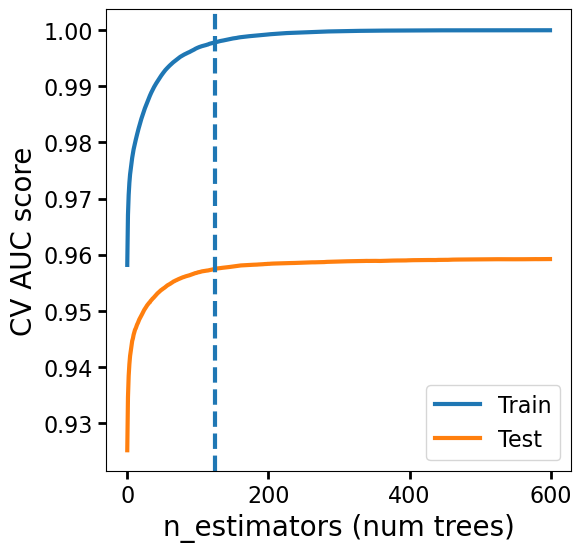

In [24]:
n_estimators = 125
fig, ax = plt.subplots()
ax.plot(score.index, score['train-auc-mean'], label='Train')
ax.plot(score.index, score['test-auc-mean'], label='Test')
ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

# SPOCK

We can now train the final spock model

In [15]:
from sklearn import metrics
from sklearn.metrics import roc_curve, confusion_matrix, auc
def ROC_curve( model, x,y):
    preds = model.predict_proba(x)[:,1]
    fpr, tpr, ROCthresholds = roc_curve(y, preds)
    roc_auc = metrics.roc_auc_score(y, preds)
    return roc_auc, fpr, tpr, ROCthresholds

0.3862876254180602

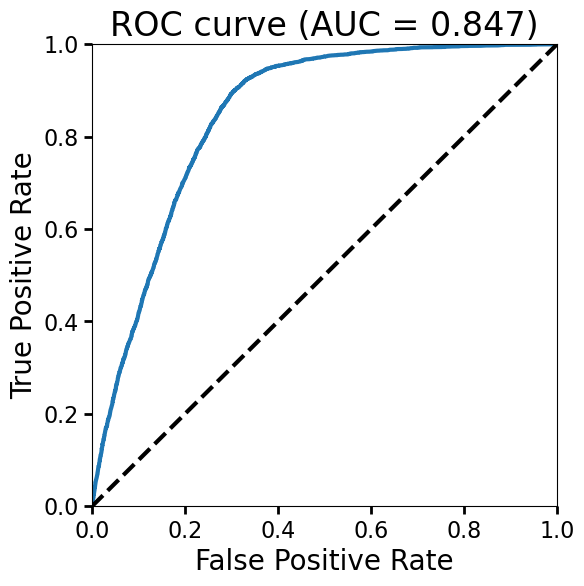

In [44]:
MEGNO = XGBClassifier(learning_rate = 0.06, 
                         max_depth = 15, 
                         subsample = 0.95,
                         min_child_weight = 5,
                         n_estimators = 200,
                         scale_pos_weight=trainingBalance)
MEGNO.fit(trainX['MEGNO'],trainY)
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(MEGNO, testX['MEGNO'], testY)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))
tprthreshindex = np.where(tpr >=0.95)[0][0]
fpr[tprthreshindex]

In [45]:
model = XGBClassifier(learning_rate = 0.06, 
                         max_depth = 30, 
                         subsample = 0.95,
                         min_child_weight = 5,
                         n_estimators = 400,
                         scale_pos_weight=trainingBalance)

In [36]:
trainX

,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,twoMMRstrengthnear,EMcrossfar,EMfracstdfar,EPstdfar,MMRstrengthfar,twoMMRstrengthfar,...,MEGNO,MEGNOstd,threeBRfillfac,3Bfirstfillfac,threeBRfillstd,chiSec,3BRfirstfillfac,z12,z23,2BRindicator
0,0.060234,0.030731,0.000280,0.492343,0.031640,0.504063,0.000879,0.000331,0.000462,0.000225,...,1.991953,0.003632,2.078270,NaN,0.061070,0.074215,0.016756,0.159918,5.244414,-0.979529
1,0.080547,0.017354,0.000137,0.470663,0.076012,0.240504,0.008916,0.002137,0.008222,0.002698,...,1.994997,0.003733,1.074720,NaN,0.033099,0.019085,0.061279,0.116510,7.023879,-0.554394
2,0.129660,0.028864,0.001000,0.984140,0.018338,1.001981,0.000493,0.000929,0.010450,0.000045,...,1.975158,0.015647,0.546220,NaN,0.002847,0.161031,0.121648,1.226457,0.141840,-1.230225
3,0.406112,0.038095,0.000937,0.313819,0.001017,0.427768,0.035029,0.003539,0.012655,0.003790,...,2.002432,0.000677,0.135609,NaN,0.000076,0.765549,0.024363,0.242646,0.419041,0.429598
4,0.059897,0.021915,0.001986,0.320414,0.016365,0.257596,0.052388,0.001360,0.033730,0.006125,...,1.805709,0.080580,2.466281,NaN,0.027442,0.753308,0.304275,2.367475,0.569861,-0.974648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81992,0.525237,0.037794,0.001424,0.012251,0.009484,0.587843,0.097799,0.064841,0.651155,0.000000,...,60.916613,18.170582,0.137189,NaN,0.002131,0.141592,0.023335,0.904901,1.027718,1.192382
81993,0.047094,0.020919,0.000528,0.469422,0.022736,0.082328,0.161638,0.008791,0.291215,0.007344,...,2.010262,0.037020,2.101111,NaN,0.018774,0.987331,0.217834,5.211851,1.409973,-1.047636
81994,0.130226,0.040008,0.001917,2.134017,0.051999,0.693580,0.044081,0.027472,0.000499,0.000356,...,2.058223,0.017598,1.966917,NaN,0.032126,0.002798,0.021569,0.318229,5.857718,-1.046755
81995,0.266853,NaN,NaN,NaN,NaN,0.311340,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.015456,0.904204,2.543309,0.889791,NaN


In [46]:
model.fit(trainX,trainY)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Text(0.5, 1.0, 'ROC curve (AUC = 0.964)')

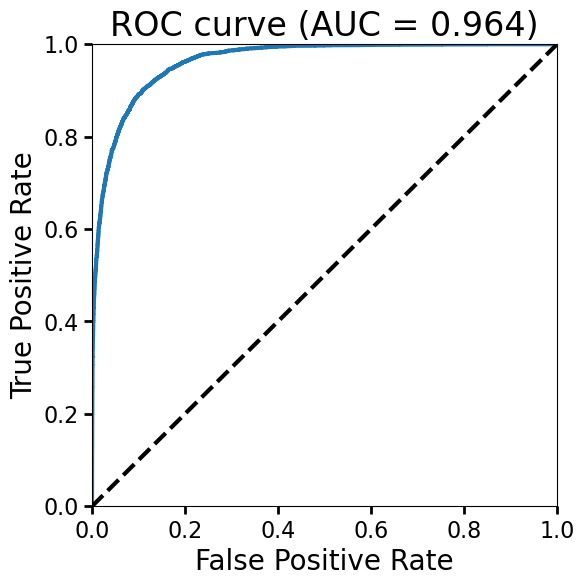

In [47]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(model, testX, testY)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [49]:
tprthreshindex = np.where(tpr >=0.95)[0][0]
fpr[tprthreshindex]

0.1758639910813824

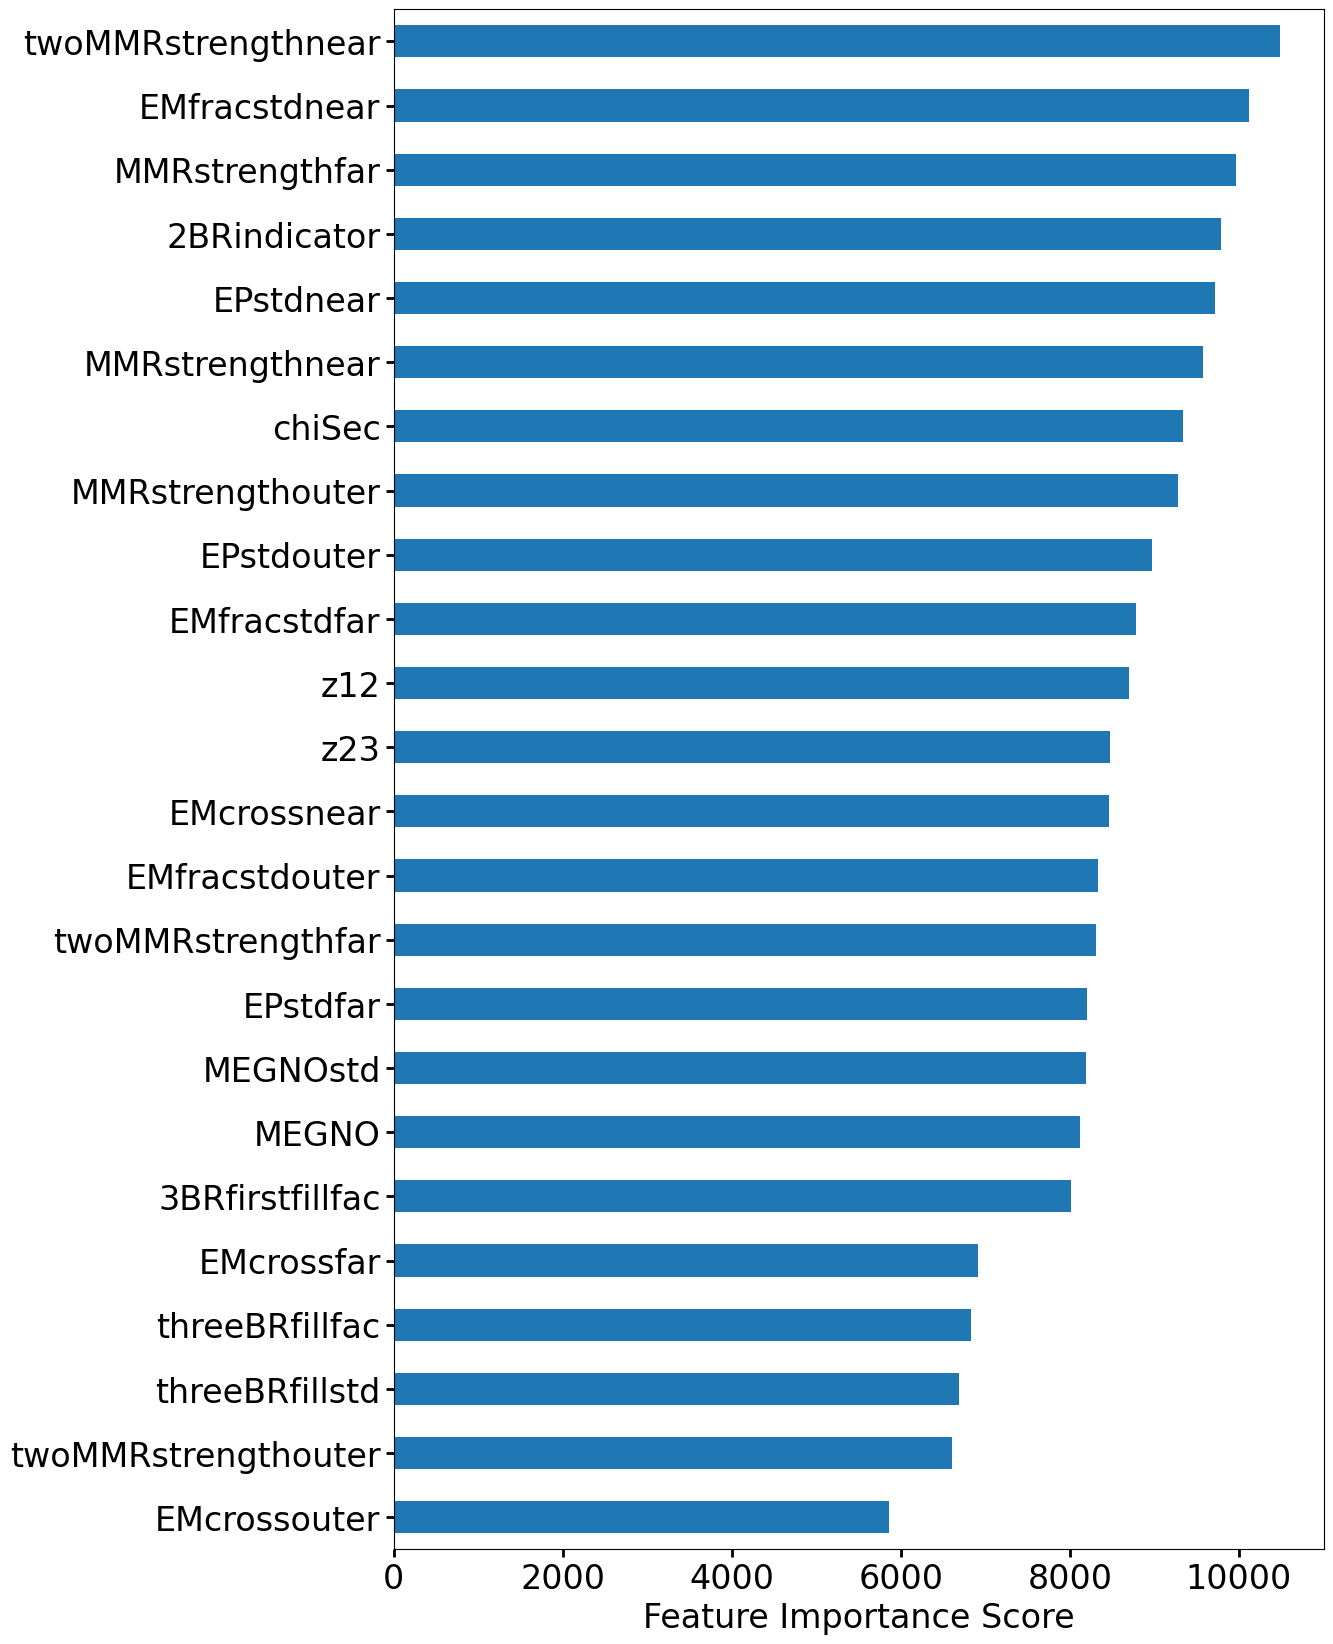

In [50]:
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,20), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()

In [14]:
test = XGBClassifier()
test.load_model('featureclassifier.json')

Text(0.5, 1.0, 'ROC curve (AUC = 0.945)')

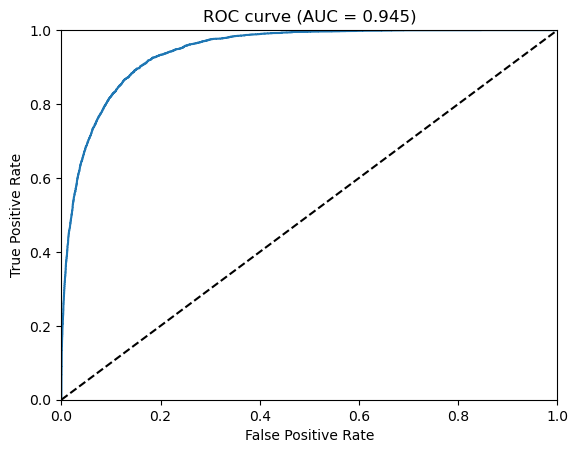

In [15]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(test, testX, testY)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))